````{admonition} Copyright 2018 The TensorFlow Authors.
```
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```
````

In [1]:
# !pip install tensorflow[and-cuda] -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 设置日志级别为ERROR，以减少警告信息
# 禁用 Gemini 的底层库（gRPC 和 Abseil）在初始化日志警告
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "3"  # 0: INFO, 1: WARNING, 2: ERROR, 3: FATAL
os.environ["GLOG_minloglevel"] = "true"
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
!export TF_FORCE_GPU_ALLOW_GROWTH=true
from pathlib import Path
temp_dir = Path(".temp")
temp_dir.mkdir(parents=True, exist_ok=True)

# Eager Execution


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/guide/eager"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看 </a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/eager.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/eager.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>   </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/eager.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

TensorFlow 的 Eager Execution 是一种命令式编程环境，可立即评估运算，无需构建计算图：运算会返回具体的值，而非构建供稍后运行的计算图。这样能使您轻松入门 TensorFlow 并调试模型，同时也减少了样板代码。要跟随本指南进行学习，请在交互式 `python` 解释器中运行以下代码示例。

Eager Execution 是用于研究和实验的灵活机器学习平台，具备以下特性：

- *直观的界面* - 自然地组织代码结构并使用 Python 数据结构。快速迭代小模型和小数据。
- *更方便的调试功能* - 直接调用运算以检查正在运行的模型并测试更改。使用标准 Python 调试工具立即报告错误。
- *自然的控制流* - 使用 Python 而非计算图控制流，简化了动态模型的规范。

Eager Execution 支持大部分 TensorFlow 运算和 GPU 加速。

注：启用 Eager Execution 后可能会增加某些模型的开销。我们正在持续改进其性能，如果您遇到问题，请[提交错误报告](https://github.com/tensorflow/tensorflow/issues)并分享您的基准。

## 设置和基本用法

In [3]:
import tensorflow as tf

在 Tensorflow 2.0 中，默认启用 Eager Execution。

In [4]:
tf.executing_eagerly()

True

现在您可以运行 TensorFlow 运算，结果将立即返回：

In [5]:
x = [[2.]]
m = tf.matmul(x, x)
print(f"hello, {m}")

hello, [[4.]]


启用 Eager Execution 会改变 TensorFlow 运算的行为方式 - 现在它们会立即评估并将值返回给 Python。`tf.Tensor` 对象会引用具体值，而非指向计算图中节点的符号句柄。由于无需构建计算图并稍后在会话中运行，可以轻松使用 `print()` 或调试程序检查结果。评估、输出和检查张量值不会中断计算梯度的流程。

Eager Execution 可以很好地配合 [NumPy](http://www.numpy.org/) 使用。NumPy 运算接受 `tf.Tensor` 参数。TensorFlow `tf.math` 运算会将 Python 对象和 NumPy 数组转换为 `tf.Tensor` 对象。`tf.Tensor.numpy` 方法会以 NumPy `ndarray` 的形式返回该对象的值。

In [6]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [7]:
# Broadcasting support
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [8]:
# Operator overloading is supported
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [9]:
# Use NumPy values
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [10]:
# Obtain numpy value from a tensor:
print(a.numpy())
# => [[1 2]
#     [3 4]]

[[1 2]
 [3 4]]


## 动态控制流

Eager Execution 的主要优势是，在执行模型时，主机语言的所有功能均可用。因此，编写 [fizzbuzz](https://en.wikipedia.org/wiki/Fizz_buzz) 之类的代码会很容易：

In [11]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [12]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


这段代码具有依赖于张量值的条件语句并会在运行时输出这些值。

## Eager 训练

### 计算梯度

[自动微分](https://en.wikipedia.org/wiki/Automatic_differentiation)对实现机器学习算法（例如用于训练神经网络的[反向传播](https://en.wikipedia.org/wiki/Backpropagation)）十分有用。在 Eager Execution 期间，请使用 `tf.GradientTape` 跟踪运算以便稍后计算梯度。

您可以在 Eager Execution 中使用 `tf.GradientTape` 来训练和/或计算梯度。这对复杂的训练循环特别有用。

由于在每次调用期间都可能进行不同运算，所有前向传递的运算都会记录到“条带”中。要计算梯度，请反向播放条带，然后丢弃。特定 `tf.GradientTape` 只能计算一个梯度；后续调用会引发运行时错误。

In [13]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad)  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


### 训练模型

以下示例创建了一个多层模型，该模型会对标准 MNIST 手写数字进行分类。示例演示了在 Eager Execution 环境中构建可训练计算图的优化器和层 API。

In [14]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [15]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

即使没有训练，也可以在 Eager Execution 中调用模型并检查输出：

In [16]:
for images,labels in dataset.take(1):
  print(f"Logits: {mnist_model(images[0:1]).numpy()}")

W0000 00:00:1729821189.283875 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821189.416974 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821189.417697 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821189.553572 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821189.567051 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821189.570972 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821189.575141 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821189.575853 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821189.576546 3867637 gp

Logits: [[ 0.06389547 -0.01810179 -0.00086157  0.00050354 -0.01409939  0.10990597
   0.00119245  0.0815191  -0.00687689  0.01905107]]


W0000 00:00:1729821190.764607 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821190.765182 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821190.765775 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821190.766359 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821190.766878 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821190.767488 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821190.768025 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821190.768576 3867637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729821190.769123 3867637 gp

虽然 Keras 模型有内置训练循环（使用 `fit` 方法），但有时您需要进行更多自定义。下面是一个使用 Eager Execution 实现训练循环的示例：

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

注：请在 `tf.debugging` 中使用断言函数检查条件是否成立。这在 Eager Execution 和计算图执行中均有效。

In [18]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)
    
    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))
    
    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [19]:
def train(epochs):
  for epoch in range(epochs):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print (f'Epoch {epoch} finished')

In [20]:
train(epochs = 3)

Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

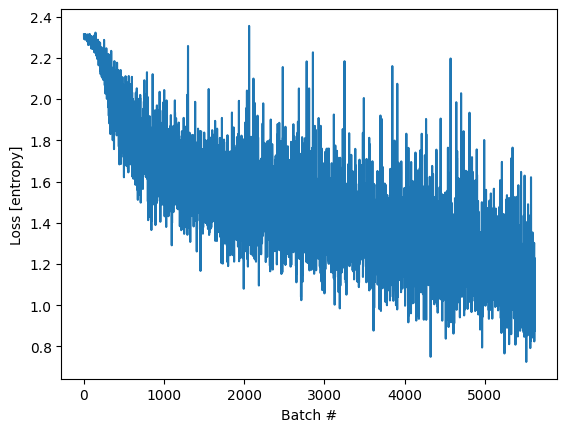

In [21]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

### 变量和优化器

`tf.Variable` 对象会存储在训练期间访问的可变、类似于 `tf.Tensor` 的值，以更简单地实现自动微分。

变量的集合及其运算方法可以封装到层或模型中。有关详细信息，请参阅[自定义 Keras 层和模型](https://render.githubusercontent.com/view/keras/custom_layers_and_models.ipynb)。层和模型之间的主要区别在于模型添加了如下方法：`Model.fit`、`Model.evaluate` 和 `Model.save`。

例如，上面的自动微分示例可以改写为：

In [22]:
class Linear(tf.keras.Model):
  def __init__(self):
    super(Linear, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

In [23]:
# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

下一步：

1. 创建模型。
2. 损失函数对模型参数的导数。
3. 基于导数的变量更新策略。

In [24]:
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

steps = 300
for i in range(steps):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

Initial loss: 68.360
Loss at step 000: 65.715
Loss at step 020: 30.047
Loss at step 040: 14.043
Loss at step 060: 6.861
Loss at step 080: 3.638
Loss at step 100: 2.191
Loss at step 120: 1.541
Loss at step 140: 1.250
Loss at step 160: 1.119
Loss at step 180: 1.060
Loss at step 200: 1.033
Loss at step 220: 1.022
Loss at step 240: 1.016
Loss at step 260: 1.014
Loss at step 280: 1.013


In [25]:
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Final loss: 1.012


In [26]:
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

W = 3.027235984802246, B = 2.0189945697784424


注：变量将一直存在，直至删除对 Python 对象的最后一个引用，并删除该变量。

### 基于对象的保存


`tf.keras.Model` 包括一个方便的 `save_weights` 方法，您可以通过该方法轻松创建检查点： 

In [27]:
model.save_weights(temp_dir/'test.weights.h5')
status = model.load_weights(temp_dir/'test.weights.h5')

您可以使用 `tf.train.Checkpoint` 完全控制此过程。

本部分是[检查点训练指南](https://render.githubusercontent.com/view/checkpoint.ipynb)的缩略版。


In [28]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [29]:
x.assign(2.)   # Assign a new value to the variables and save.
checkpoint_path = temp_dir/'ckpt/'
checkpoint.save(checkpoint_path)

'.temp/ckpt-1'

In [30]:
x.assign(11.)  # Change the variable after saving.

# Restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=11.0>


要保存和加载模型，`tf.train.Checkpoint` 会存储对象的内部状态，而无需隐藏变量。要记录 `model`、`optimizer` 和全局步骤的状态，请将它们传递到 `tf.train.Checkpoint`：

In [31]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = temp_dir/'model_dir'
if not checkpoint_dir.exists():
  checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_prefix = checkpoint_dir/"ckpt"
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

注：在许多训练循环中，会在调用 `tf.train.Checkpoint.restore` 后创建变量。这些变量将在创建后立即恢复，并且可以使用断言来确保检查点已完全加载。有关详细信息，请参阅[检查点训练指南](https://render.githubusercontent.com/view/checkpoint.ipynb)。

### 面向对象的指标

`tf.keras.metrics` 会被存储为对象。可以通过将新数据传递给可调用对象来更新指标，并使用 `tf.keras.metrics.result` 方法检索结果，例如：

In [32]:
m = tf.keras.metrics.Mean("loss")
m(0)
m(5)
m.result()  # => 2.5
m([8, 9])
m.result()  # => 5.5

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

### 摘要和 TensorBoard

[TensorBoard](https://tensorflow.google.cn/tensorboard) 是一种可视化工具，用于了解、调试和优化模型训练过程。它使用在执行程序时编写的摘要事件。

您可以在 Eager Execution 中使用 `tf.summary` 记录变量摘要。例如，要每 100 个训练步骤记录一次 `loss` 的摘要，请运行以下代码：

In [33]:
logdir = str(temp_dir/"tb")
writer = tf.summary.create_file_writer(logdir)

steps = 1000
with writer.as_default():  # or call writer.set_as_default() before the loop.
  for i in range(steps):
    step = i + 1
    # Calculate loss with your real train function.
    loss = 1 - 0.001 * step
    if step % 100 == 0:
      tf.summary.scalar('loss', loss, step=step)

In [34]:
!ls {temp_dir}/tb/

events.out.tfevents.1729700034.Alg.2944560.0.v2
events.out.tfevents.1729821414.Alg.3867637.0.v2


## 自动微分高级主题

### 动态模型

`tf.GradientTape` 也可以用于动态模型。下面这个[回溯线搜索](https://wikipedia.org/wiki/Backtracking_line_search)算法示例看起来就像普通的 NumPy 代码，但它的控制流比较复杂，存在梯度且可微分：

In [35]:
def line_search_step(fn, init_x, rate=1.0):
  with tf.GradientTape() as tape:
    # Variables are automatically tracked.
    # But to calculate a gradient from a tensor, you must `watch` it.
    tape.watch(init_x)
    value = fn(init_x)
  grad = tape.gradient(value, init_x)
  grad_norm = tf.reduce_sum(grad * grad)
  init_value = value
  while value > init_value - rate * grad_norm:
    x = init_x - rate * grad
    value = fn(x)
    rate /= 2.0
  return x, value

### 自定义梯度

自定义梯度是重写梯度的一种简单方法。在前向函数中，定义相对于输入、输出或中间结果的梯度。例如，下面是在后向传递中裁剪梯度范数的一种简单方法：

In [36]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
  y = tf.identity(x)
  def grad_fn(dresult):
    return [tf.clip_by_norm(dresult, norm), None]
  return y, grad_fn

自定义梯度通常用来为运算序列提供数值稳定的梯度：

In [37]:
def log1pexp(x):
  return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)


In [38]:
# The gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [39]:
# However, x = 100 fails because of numerical instability.
grad_log1pexp(tf.constant(100.)).numpy()

nan

在此例中，`log1pexp` 函数可以通过自定义梯度进行分析简化。下面的实现重用了在前向传递期间计算的 `tf.exp(x)` 值，通过消除冗余计算使其变得更加高效：

In [40]:
@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)


In [41]:
# As before, the gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [42]:
# And the gradient computation also works at x = 100.
grad_log1pexp(tf.constant(100.)).numpy()

1.0

## 性能

在 Eager Execution 期间，计算会自动分流到 GPU。如果想控制计算运行的位置，可将其放在 `tf.device('/gpu:0')` 块（或 CPU 等效块）中：

In [43]:
import time

def measure(x, steps):
  # TensorFlow initializes a GPU the first time it's used, exclude from timing.
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  # tf.matmul can return before completing the matrix multiplication
  # (e.g., can return after enqueing the operation on a CUDA stream).
  # The x.numpy() call below will ensure that all enqueued operations
  # have completed (and will also copy the result to host memory,
  # so we're including a little more than just the matmul operation
  # time).
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
  print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# Run on GPU, if available:
if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
  print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 0.5543513298034668 secs
GPU: 0.029835224151611328 secs


可以将 `tf.Tensor` 对象复制到不同设备来执行其运算：

In [44]:
if tf.config.experimental.list_physical_devices("GPU"):
  x = tf.random.normal([10, 10])

  x_gpu0 = x.gpu()
  x_cpu = x.cpu()

  _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
  _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0

### 基准

对于计算量繁重的模型（如在 GPU 上训练的 [ResNet50](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/resnet50)），Eager Execution 性能与 `tf.function` 执行相当。但是对于计算量较小的模型来说，这种性能差距会越来越大，并且在为有大量小运算的模型优化热代码路径方面，其性能还有待提升。

## 使用函数

虽然 Eager Execution 增强了开发和调试的交互性，但 TensorFlow 1.x 样式的计算图执行在分布式训练、性能优化和生产部署方面具有优势。为了弥补这一差距，TensorFlow 2.0 通过 `tf.function` API 引入了 `function`。有关详细信息，请参阅 [tf.function](https://render.githubusercontent.com/view/function.ipynb) 指南。